In [123]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit
import qlm
import importlib
import matspy

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [108]:
importlib.reload(qlm)

<module 'qlm' from '/home/ian/Projects/work/monk/workflows/2d-osc-shear/notebooks/qlms/qlm.py'>

In [109]:
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [110]:
pos = np.array([[1.0, 3.0, 0], [2.0, 2.5, 0]])
box = freud.Box.from_box([20, 20, 0, 0, 0, 0])
types = np.array([0, 0])
edges = np.array([[0, 1], [1, 0]])
dists = []
for idx in range(len(edges)):
    i, j = edges[idx]
    dists.append(np.linalg.norm(pos[i] - pos[j]))
dists = np.array(dists)
dists

array([1.11803399, 1.11803399])

In [111]:
box

freud.box.Box(Lx=20.0, Ly=20.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, is2D=True)

In [115]:
hess = computer.compute_hessian_with_nlist(pos, dists, edges, types, box, 2)

In [116]:
hess.toarray().astype(np.float16)

array([[ 49.6 , -24.92, -49.6 ,  24.92],
       [-24.92,  12.22,  24.92, -12.22],
       [-49.6 ,  24.92,  49.6 , -24.92],
       [ 24.92, -12.22, -24.92,  12.22]], dtype=float16)

In [117]:
hess = computer.compute_hessian_with_nlist(pos, dists, edges, types, box, 2, dense=True)
hess.astype(np.float16)

array([[ 49.6 , -24.92, -49.6 ,  24.92],
       [-24.92,  12.22,  24.92, -12.22],
       [-49.6 ,  24.92,  49.6 , -24.92],
       [ 24.92, -12.22, -24.92,  12.22]], dtype=float16)

In [147]:
hess[:5, :5].toarray().astype(np.float16)

array([[195.  ,  57.6 ,   0.  ,   0.  ,   0.  ],
       [ 57.6 , 172.8 ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  , 210.6 ,  18.17, -87.  ],
       [  0.  ,   0.  ,  18.17, 324.5 , -56.88],
       [  0.  ,   0.  , -87.  , -56.88, 275.5 ]], dtype=float16)

In [132]:
pos = np.array([[1.0, 3.0, 0], [2.0, 2.5, 0], [0.0, 2.0, 0.0], [0.5, 2.5, 0.0]])
box = freud.Box.from_box([20, 20, 0, 0, 0, 0])
types = np.array([0, 0, 0, 0])
edges = np.array([[0, 1], [1, 0], [2, 3], [3, 2]])
dists = []
for idx in range(len(edges)):
    i, j = edges[idx]
    dists.append(np.linalg.norm(pos[i] - pos[j]))
dists = np.array(dists)
dists

array([1.11803399, 1.11803399, 0.70710678, 0.70710678])

In [133]:
importlib.reload(qlm);
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [138]:
hess = computer.compute_hessian_with_nlist(pos, dists, edges, types, box, 2)
hess.toarray().astype(np.float16)

array([[ 4.959e+01, -2.492e+01, -4.959e+01,  2.492e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-2.492e+01,  1.222e+01,  2.492e+01, -1.222e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-4.959e+01,  2.492e+01,  4.959e+01, -2.492e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.492e+01, -1.222e+01, -2.492e+01,  1.222e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  3.571e+04,
         4.147e+04, -3.571e+04, -4.147e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  4.147e+04,
         3.571e+04, -4.147e+04, -3.571e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -3.571e+04,
        -4.147e+04,  3.571e+04,  4.147e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -4.147e+04,
        -3.571e+04,  4.147e+04,  3.571e+04]], dtype=float16)

In [139]:
hess = computer.compute_hessian_with_nlist(pos, dists, edges, types, box, 2, dense=True)
hess.astype(np.float16)

array([[ 4.959e+01, -2.492e+01, -4.959e+01,  2.492e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-2.492e+01,  1.222e+01,  2.492e+01, -1.222e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-4.959e+01,  2.492e+01,  4.959e+01, -2.492e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.492e+01, -1.222e+01, -2.492e+01,  1.222e+01,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  3.571e+04,
         4.147e+04, -3.571e+04, -4.147e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  4.147e+04,
         3.571e+04, -4.147e+04, -3.571e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -3.571e+04,
        -4.147e+04,  3.571e+04,  4.147e+04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -4.147e+04,
        -3.571e+04,  4.147e+04,  3.571e+04]], dtype=float16)

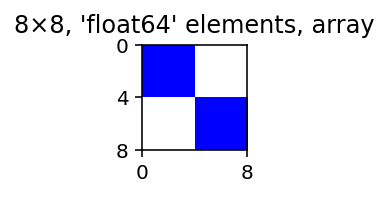

In [136]:
matspy.spy(hess)

In [22]:
importlib.reload(qlm);

In [42]:
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [43]:
output = computer.compute(traj[-1], sigma=0.0, k=20, filter=False)

In [44]:
evals = output[0]

In [45]:
evals

array([-6.03311335e-02,  1.31558506e-15,  3.68086701e-15,  6.31962034e-09,
        1.74725214e-02,  2.01788312e-02,  2.06837541e-02,  2.22169614e-02,
        3.64795254e-02,  3.94109785e-02,  4.09630777e-02,  4.27179179e-02,
        5.55456528e-02,  6.90679992e-02,  7.54373550e-02,  7.82482558e-02,
        8.20181970e-02,  8.40224930e-02,  9.13470655e-02,  9.75208119e-02])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 3., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 1., 1., 2., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 0., 2., 0., 0., 1., 1.]),
 array([-0.06033113, -0.05717409, -0.05401706, -0.05086002, -0.04770298,
        -0.04454594, -0.0413889 , -0.03823186, -0.03507482, -0.03191778,
        -0.02876074, -0.02560371, -0.02244667, -0.01928963, -0.01613259,
        -0.01297555, -0.00981851, -0.00666147, -0.00350443, -0.00034739,
         0.00280964,  0.00596668,  0.00912372,  0.01228076,  0.0154378 ,
         0.01859484,  0.02175188,  0.02490892,  0.02806596,  0.03122299,
         0.03438003,  0.03753707,  0.04069411,  0.04385115,  0.04700819,
         0.05016523,  0.05332227,  0.05647931,  0.05963634,  0.06279338,
         0.06595042,  0.06910746,  0.0722645 ,  0.07542154,  0.07857858,
         0.08173562,  0.08489266,  0.0880497 ,  0.09120673,  0.09436377,
         0.09752081]),
 <BarContainer object

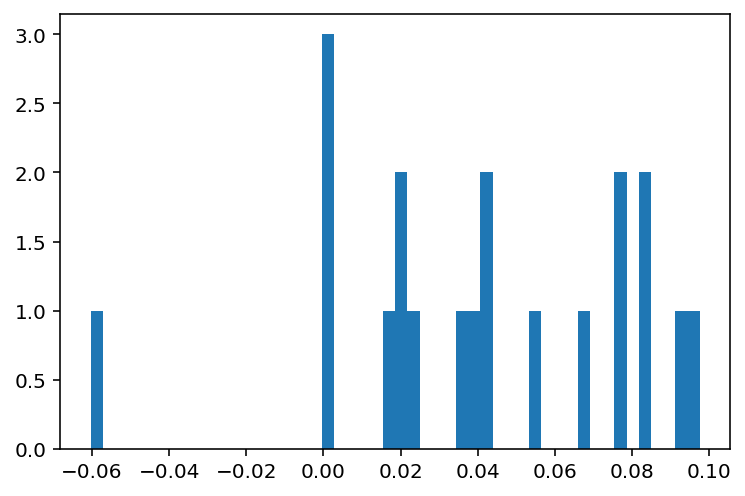

In [46]:
plt.hist(evals, bins=50)

(array([1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 3., 0., 3., 1., 1., 0., 1.,
        2., 2., 2.]),
 array([-0.06033113, -0.05243854, -0.04454594, -0.03665334, -0.02876074,
        -0.02086815, -0.01297555, -0.00508295,  0.00280964,  0.01070224,
         0.01859484,  0.02648744,  0.03438003,  0.04227263,  0.05016523,
         0.05805783,  0.06595042,  0.07384302,  0.08173562,  0.08962821,
         0.09752081]),
 <BarContainer object of 20 artists>)

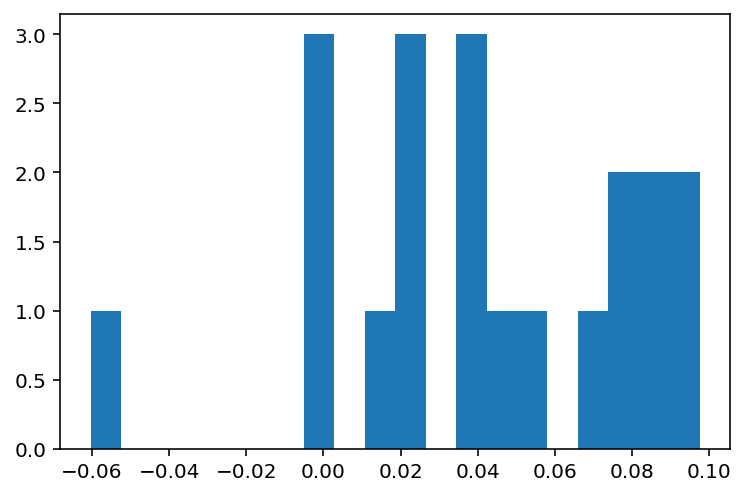

In [47]:
plt.hist(evals, bins=20)

In [48]:
N = traj[-1].particles.N

In [49]:
evals

array([-6.03311335e-02,  1.31558506e-15,  3.68086701e-15,  6.31962034e-09,
        1.74725214e-02,  2.01788312e-02,  2.06837541e-02,  2.22169614e-02,
        3.64795254e-02,  3.94109785e-02,  4.09630777e-02,  4.27179179e-02,
        5.55456528e-02,  6.90679992e-02,  7.54373550e-02,  7.82482558e-02,
        8.20181970e-02,  8.40224930e-02,  9.13470655e-02,  9.75208119e-02])

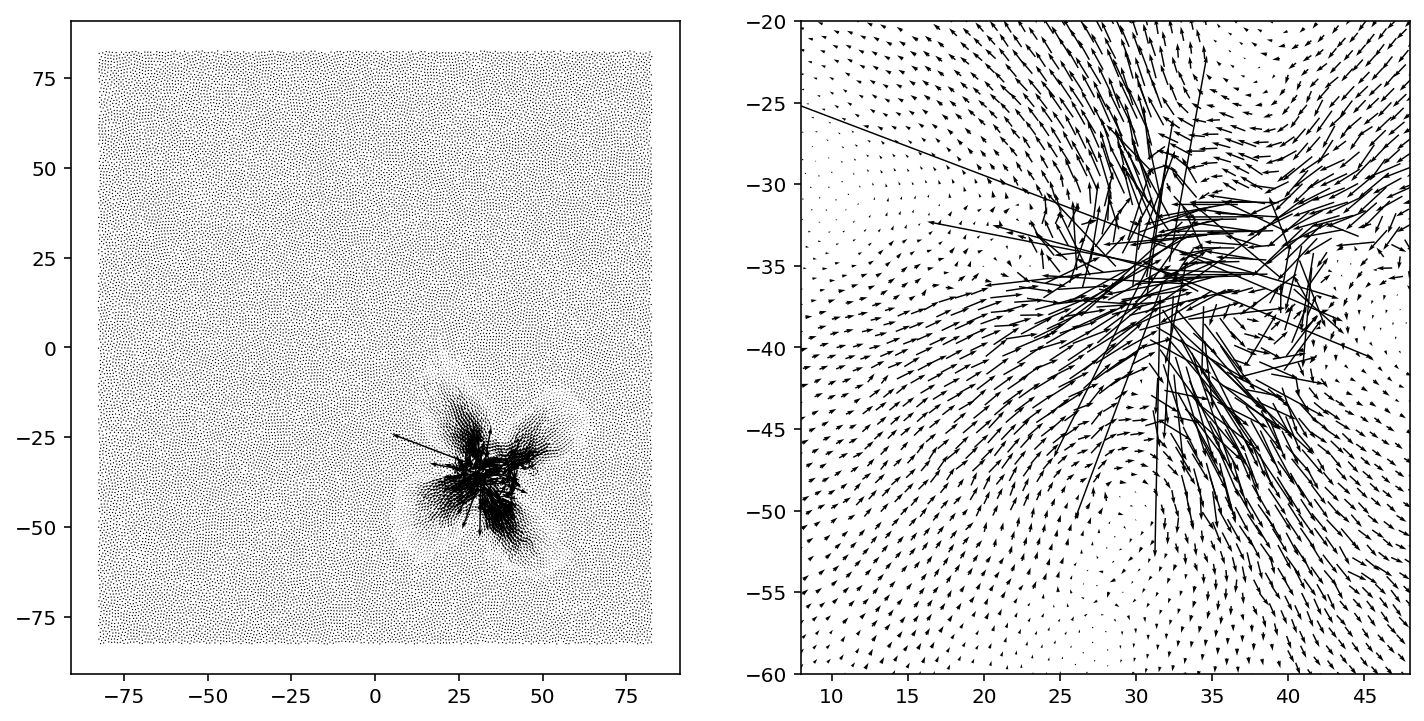

In [57]:
evec = output[1][0].reshape(N, 2) # len N*dim
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

s = 0.01

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=s, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=s, scale_units='xy')
L = 40
lx = 28
ly = -40
if L is not None:
    plt.xlim(-L/2 + lx, L/2 + lx)
    plt.ylim(-L/2 + ly, L/2 + ly)

In [241]:
np.savez("eig", evecs=output[1], evals=evals)

In [242]:
importlib.reload(qlm);
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [264]:
filtered_modes = computer.filter_modes(traj[-1], output[1][:100])

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [256]:
np.savez("eig-filtered-small-neg", evecs=filtered_modes, evals=evals)

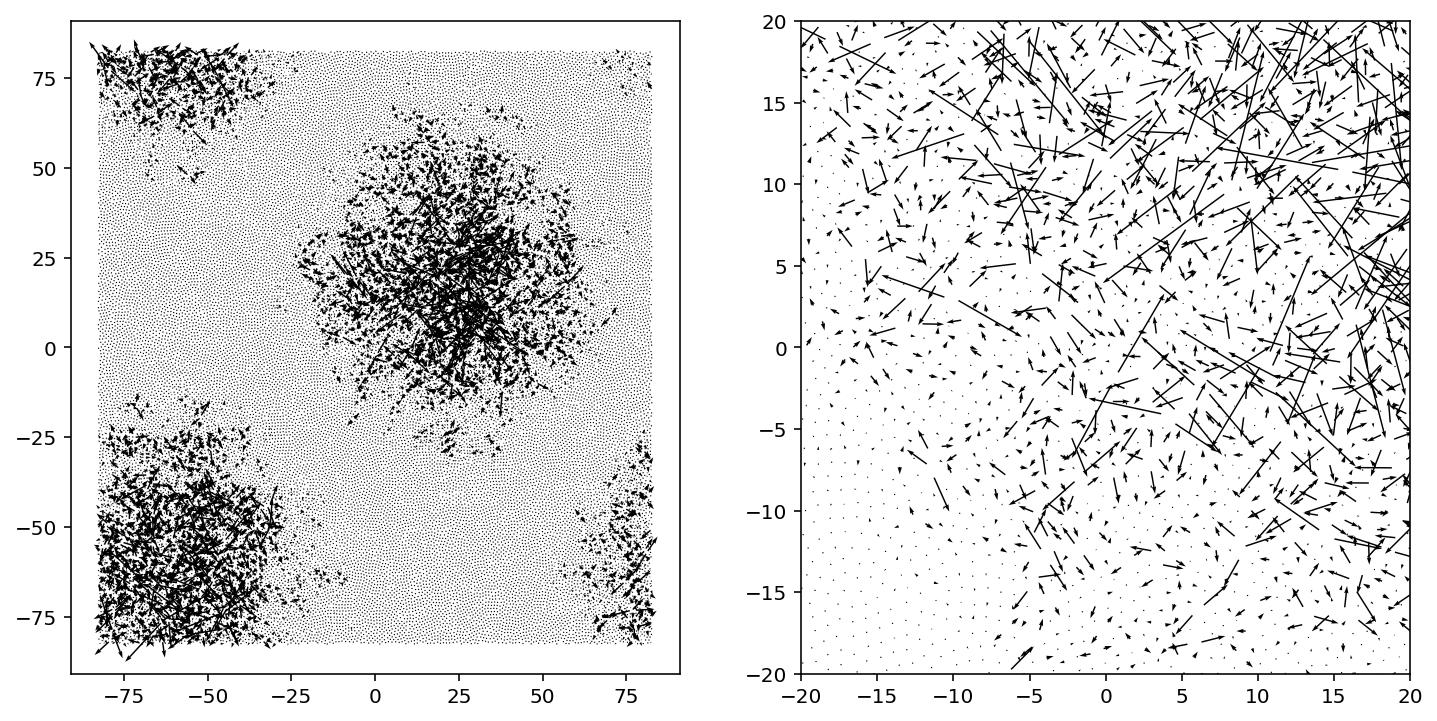

In [258]:
n = 2
evec = filtered_modes[n].reshape(N, 2).copy() # len N*dim
evec /= np.linalg.norm(evec)
# evec = np.log(np.abs(evec) + 1e-6) * np.sign(evec)
# plot eigenvectors
# plt.figure(figsize=(6, 6))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = 0.005

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = 40
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

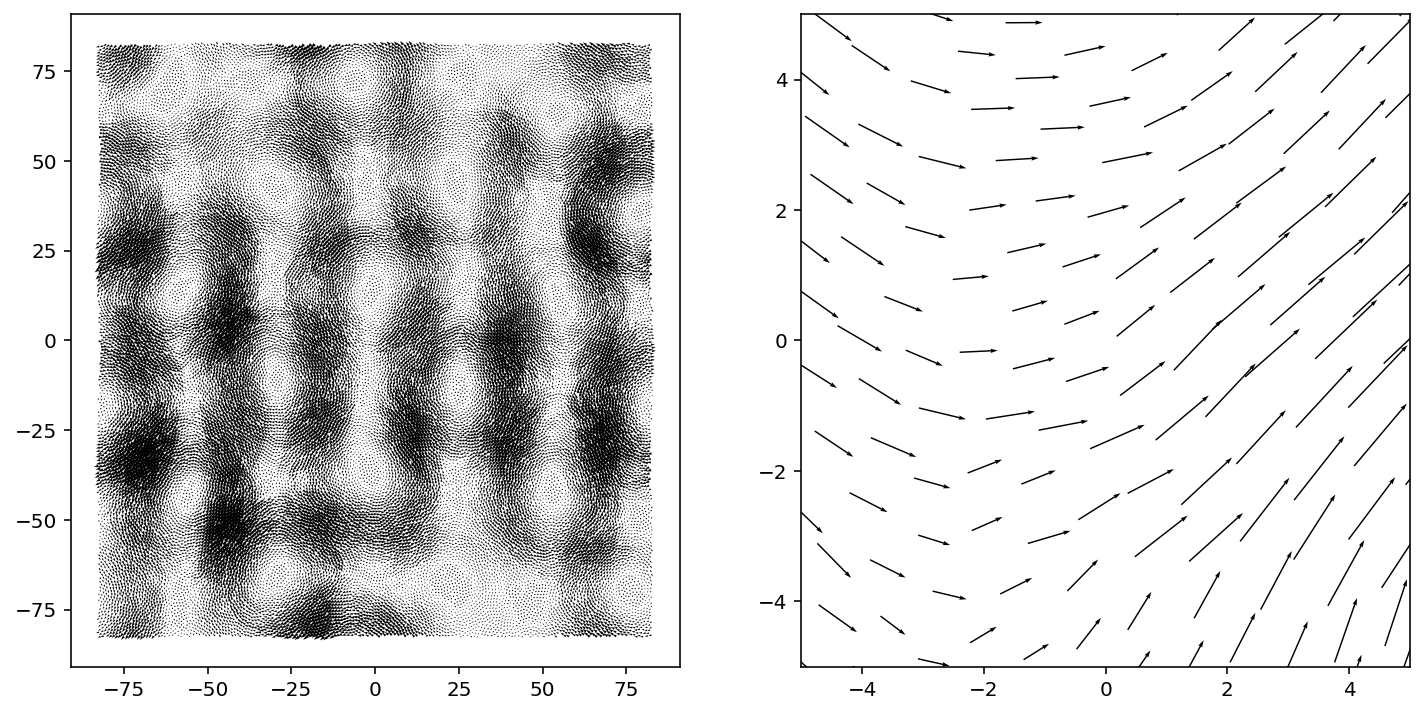

In [240]:
evec = output[1][n].reshape(N, 2).copy() # len N*dim

# plot eigenvectors
# plt.figure(figsize=(6, 6))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = 0.005

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = 10
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

In [222]:
np.linalg.norm(output[1][1000])

1.0000000000000002

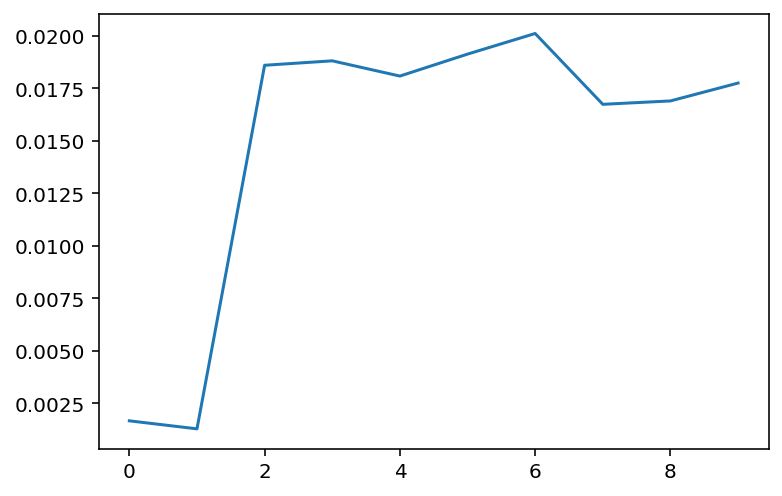

In [263]:
plt.plot(np.linalg.norm(filtered_modes, axis=1)/evals[:10])